<a href="https://colab.research.google.com/github/amjlak/gstat/blob/main/LULC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 89.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
raster1 = '/content/drive/MyDrive/MyFolder/Sentinel2_Image.tif'
points_loc = '/content/K1.shp'
temp_point_loc = '/content/K2.shp'
shapefile_loc = '/content/maya.shp'


In [ ]:
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask


In [ ]:
lulc_name = ['1', '2', '3', '4', '5', '6']

In [ ]:
src = rio.open(raster1)
blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)
nir = src.read(4, masked=True)
def normalize(array):
    """Normalizes numpy arrays into scale 0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)

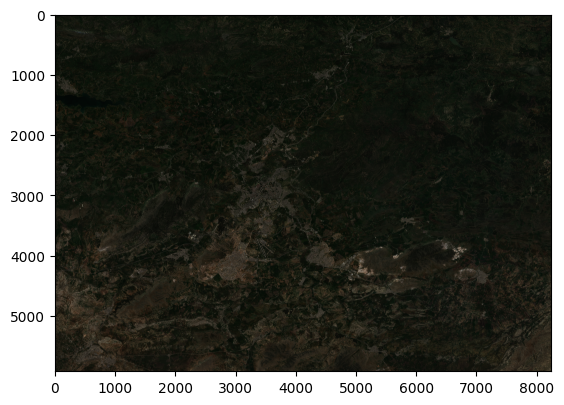

In [ ]:
rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

In [ ]:
with rio.open(raster1) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)
features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
points = points.assign(id=range(len(points)))
points.to_file(temp_point_loc)
points_df = pd.DataFrame(points.drop(columns='geometry'))
sampled = pd.Series()

with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        with rio.open(raster1) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        sampled.loc[siteID] = value

df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

ERROR:fiona._env:/content/K1.shp: No such file or directory


Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


DriverError: ignored

Accuracy CL: 36.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         2.0       1.00      1.00      1.00         3
         3.0       0.76      1.00      0.86        16
         4.0       1.00      1.00      1.00         3
         5.0       1.00      0.56      0.71         9
         6.0       1.00      0.50      0.67         2

    accuracy                           0.86        35
   macro avg       0.96      0.84      0.87        35
weighted avg       0.89      0.86      0.85        35

Confusion Matrix RF: 
 [[ 2  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0  3  0  0]
 [ 0  0  4  0  5  0]
 [ 0  0  1  0  0  1]]


Text(45.75, 0.5, 'Actual')

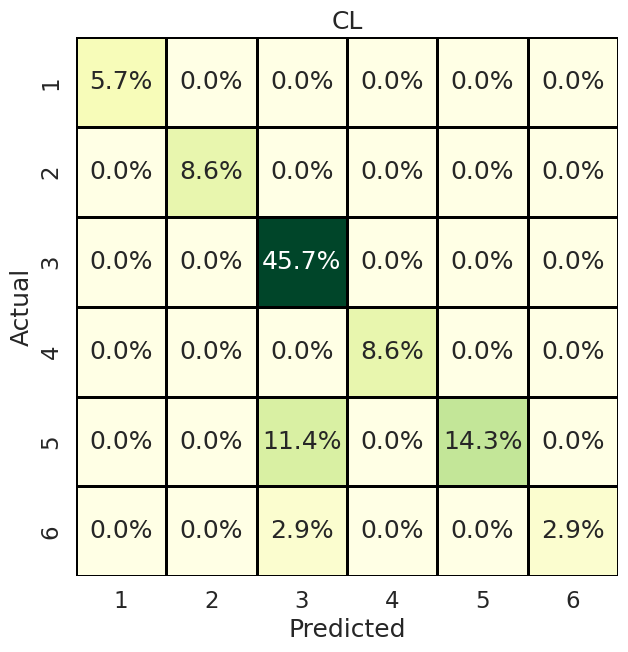

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'CL'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*42}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.1%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
%%time
cName = 'O'
exp_name = f'/content/sample_data/lulc_{cName}.tif'
img = rio.open(raster1)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 5920
Width: 8235
Bands: 4

reshaped full data shape  for prediction:  (48751200, 4)
Prediction Done, now exporting raster 

Map saved O.................
CPU times: user 4min 7s, sys: 4.63 s, total: 4min 11s
Wall time: 4min 25s


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 8235, 'height': 5920, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 6.309766555655519,
       0.0, -8.983152841195215e-05, 36.62413447049607)}


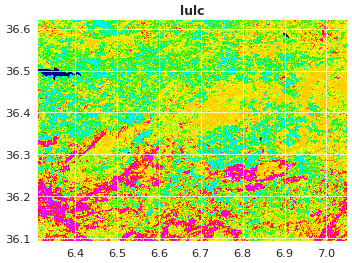

<Axes: title={'center': 'lulc'}>

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

dsm = rasterio.open("/content/sample_data/lulc_O.tif")

print(dsm.meta)

plt.figure(figsize=(8, 9), dpi=50)
show(dsm, title='lulc', cmap='gist_ncar')